# Bayesian Optimization 

N. Bartoli ONERA/DTIS/M2CI

## Objective: write an adaptive optimization algorithm using Gaussian process ${\cal N}(\mu,\sigma^2)$
* Optimization using only the surrogate model information (exploitation based on $\mu$)
* Efficient Global Optimization with Expected Improvment criterion (exploitation/exploration trade-off based on $\mu$ and $\sigma$)
* Efficient Global Optimization with Upper Confidence Bound criterion using the confidence interval : $\mu -3 \sigma$

%matplotlib inline for  google colab instead of %matplotlib notebook

<IPython.core.display.Javascript object>


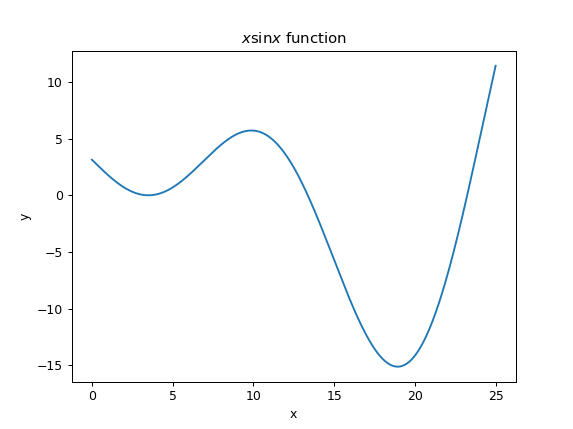

In [3]:
import numpy as np 
%matplotlib notebook
import matplotlib.pyplot as plt

plt.ion()

def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))

X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)
#y_gpr , y_std = gpr.predict(X_plot , return_std=True)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
lines.append(true_fun)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()




Here, the data are the points xdata=[0,7,25]xdata=[0,7,25]. 


In [4]:
x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

Build the GP model with a square exponential kernel with scikit-learn toolbox knowing $(x_{data}, y_{data})$.

<IPython.core.display.Javascript object>


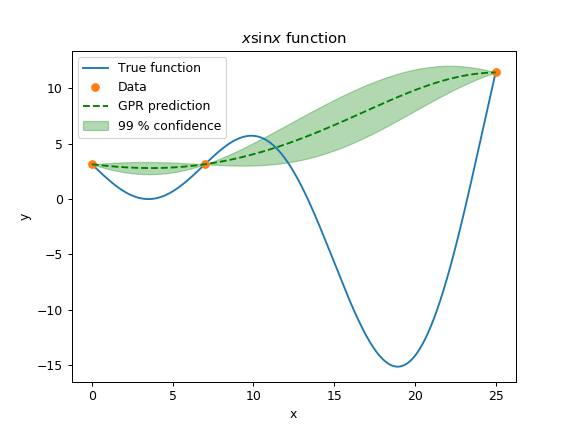

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF as SEkernel

ker = SEkernel()
gpr = GP(kernel=ker,n_restarts_optimizer=10,normalize_y=True)

gpr.fit(x_data,y_data)

Y_GP_plot = gpr.predict(X_plot,return_std=True)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()


Bayesian optimization is defined by Jonas Mockus in (Mockus, 1975) as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation that we are aware of is (Kushner, 1962 ; Kushner, 1964). Kushner used Wiener processes for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in (Mockus, 1975). This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO (Jones, 1998).

## Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in (Jones, 1998).

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us denote:
$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$
The Expected Improvement funtion (EI) can be expressed:
$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$
where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the right-hand side of EI expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 
$$
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
$$
where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$) \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

Now we want to optimize this function by using Bayesian Optimization and comparing
- Surrogate based optimization (SBO)
- Expected improvement criterion


In a first step we compute the EI criterion

<IPython.core.display.Javascript object>


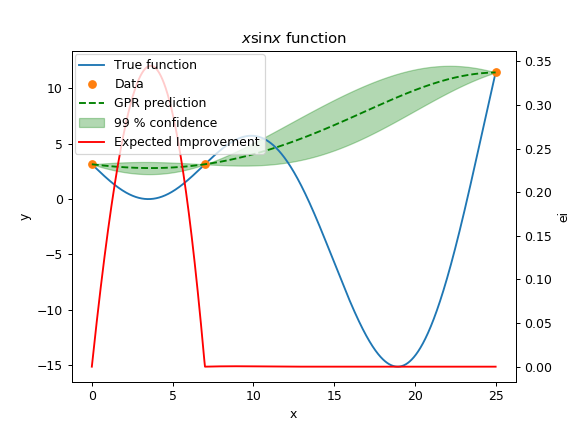

In [6]:
from scipy.stats import norm
from scipy.optimize import minimize


def EI(GP,points,f_min):
    pred = GP.predict(points,return_std=True)
    var=pred[1]
    args0 = (f_min - pred[0])/np.atleast_2d(pred[1]).T
    args1 = (f_min - pred[0])*norm.cdf(args0)
    args2 = np.atleast_2d(pred[1]).T*norm.pdf(args0)
   
    if var.size == 1 and var == 0.0:  # can be use only if one point is computed
        return 0.0
   
    ei = args1 + args2
    return ei



Y_GP_plot = gpr.predict(X_plot,return_std=True)
Y_EI_plot = EI(gpr,X_plot,np.min(y_data))

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
ax1 = ax.twinx()
ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
lines = [true_fun,data,gp,un_gp,ei]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax1.set_ylabel('ei')
fig.legend(lines,['True function','Data','GPR prediction','99 % confidence','Expected Improvement'],loc=[0.13,0.64])
plt.show()

Now we compute the EGO method and compare it to other infill criteria 
- SBO (surrogate based optimization): directly using the prediction of the surrogate model ($\mu$)
- UCB (Upper Confidence bound): using the confidence interval : $\mu -3 \times \sigma$
- EI for expected Improvement (EGO)

In [7]:
#surrogate Based optimization: min the Surrogate model by using the mean mu
def SBO(GP,point):
    res = GP.predict(point)
    return res

#upper confidence bound optimization: minimize by using mu - 3*sigma
def UCB(GP,point):
    pred = GP.predict(point,return_std=True)
    res = pred[0]-3.*np.atleast_2d(pred[1]).T
    return res


In [8]:
IC = 'EI'

In [9]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML



plt.ioff()

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

n_iter = 15
ker = SEkernel()
gpr = gpr = GP(kernel=ker,n_restarts_optimizer=10,normalize_y=True)





for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(20)*25).T
    f_min_k = np.min(y_data)
    gpr.fit(x_data,y_data)
    
    if IC == 'EI':
        obj_k = lambda x: -EI(gpr,np.atleast_2d(x),f_min_k)
    elif IC =='SBO':
        obj_k = lambda x: SBO(gpr,np.atleast_2d(x))
    elif IC == 'UCB':
        obj_k = lambda x: UCB(gpr,np.atleast_2d(x))
    
    opt_all = np.array([minimize(obj_k, x_st, method='SLSQP', bounds=[(0,25)]) for x_st in x_start])
    opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
    obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt['x']
    
    y_et_k = fun(x_et_k)
    
    y_data = np.atleast_2d(np.append(y_data,y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data,x_et_k)).T
    
    Y_GP_plot = gpr.predict(X_plot,return_std=True)
    Y_EI_plot = obj_k(X_plot)

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    if IC == 'UCB' or IC == 'SBO':
        ei, = ax.plot(X_plot,Y_EI_plot,color='red')
    else:    
        ax1 = ax.twinx()
        ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
    true_fun, = ax.plot(X_plot,Y_plot)
    data, = ax.plot(x_data[0:k+3],y_data[0:k+3],linestyle='',marker='o',color='orange')
    opt, = ax.plot(x_data[k+3],y_data[k+3],linestyle='',marker='*',color='r')
    gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
    sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
    sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
    un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
    lines = [true_fun,data,gp,un_gp,opt,ei]
    ax.set_title('$x \sin{x}$ function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(lines,['True function','Data','GPR prediction','99 % confidence','Next point to Evaluate','Infill Criteria'])
    plt.savefig('Optimisation %d' %k)
    plt.close(fig)
    
ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print('Results : X = %s, Y = %s' %(x_opt,y_opt))
print('Xopt test 1D ', x_opt,y_opt, ' obtained using EGO criterion = ', IC )
print('Check if the optimal point is Xopt= (1,1) with the Y value=0')
print('---------------------------')

print('Check if the optimal point is Xopt= (array([18.9013862]), array([-15.12415518])')
print('---------------------------')

fig = plt.figure(figsize=[10,10])

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ims = []
for k in range(n_iter):
    image_pt = mpimg.imread('Optimisation %d.png' %k)
    im = plt.imshow(image_pt)
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims,interval=500)
HTML(ani.to_jshtml())

D:\bartoli\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
D:\bartoli\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
D:\bartoli\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divid

D:\bartoli\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
D:\bartoli\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
D:\bartoli\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divid

Results : X = [18.93163054], Y = [-15.1250926]
Xopt test 1D  [18.93163054] [-15.1250926]  obtained using EGO criterion =  EI
Check if the optimal point is Xopt= (1,1) with the Y value=0
---------------------------
Check if the optimal point is Xopt= (array([18.9013862]), array([-15.12415518])
---------------------------


## Recap: Play with a web app from Rasmussen

https://drafts.distill.pub/gp/

## Try with a 2D function : 2D Rosenbrock function 


Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$
    

In [10]:
def rosenbrock(x):
    """
    Evaluate objective and constraints for the Rosenbrock test case:
    """
    n,dim = x.shape

    #parameters:
    Opt =[]
    Opt_point_scalar = 1
    #construction of O vector
    for i in range(0, dim):
        Opt.append(Opt_point_scalar)

    #Construction of Z vector
    Z= np.zeros((n,dim))
    for i in range(0,dim):
        Z[:,i] = (x[:,i]-Opt[i]+1)

    #Sum
    sum1 = np.zeros((n,1))
    for i in range(0,dim-1):
        sum1[:,0] += 100*(((Z[:,i]**2)-Z[:,i+1])**2)+((Z[:,i]-1)**2)

    return sum1

---------------------------
PLOT  2D Rosenbrock 


<IPython.core.display.Javascript object>


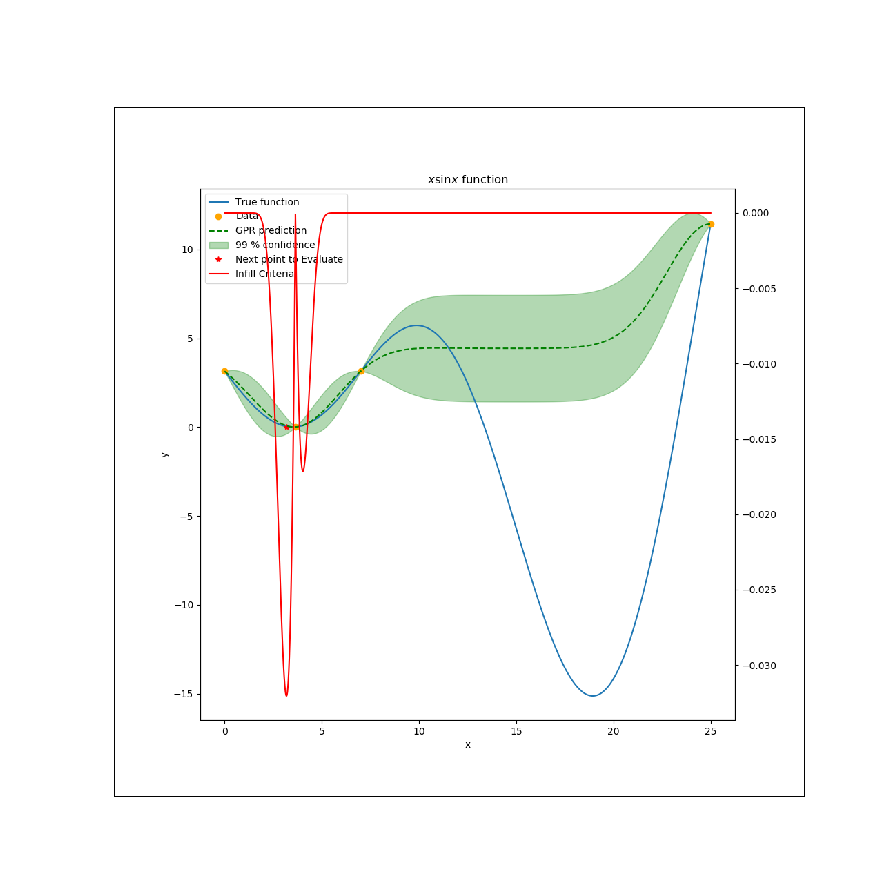

<IPython.core.display.Javascript object>


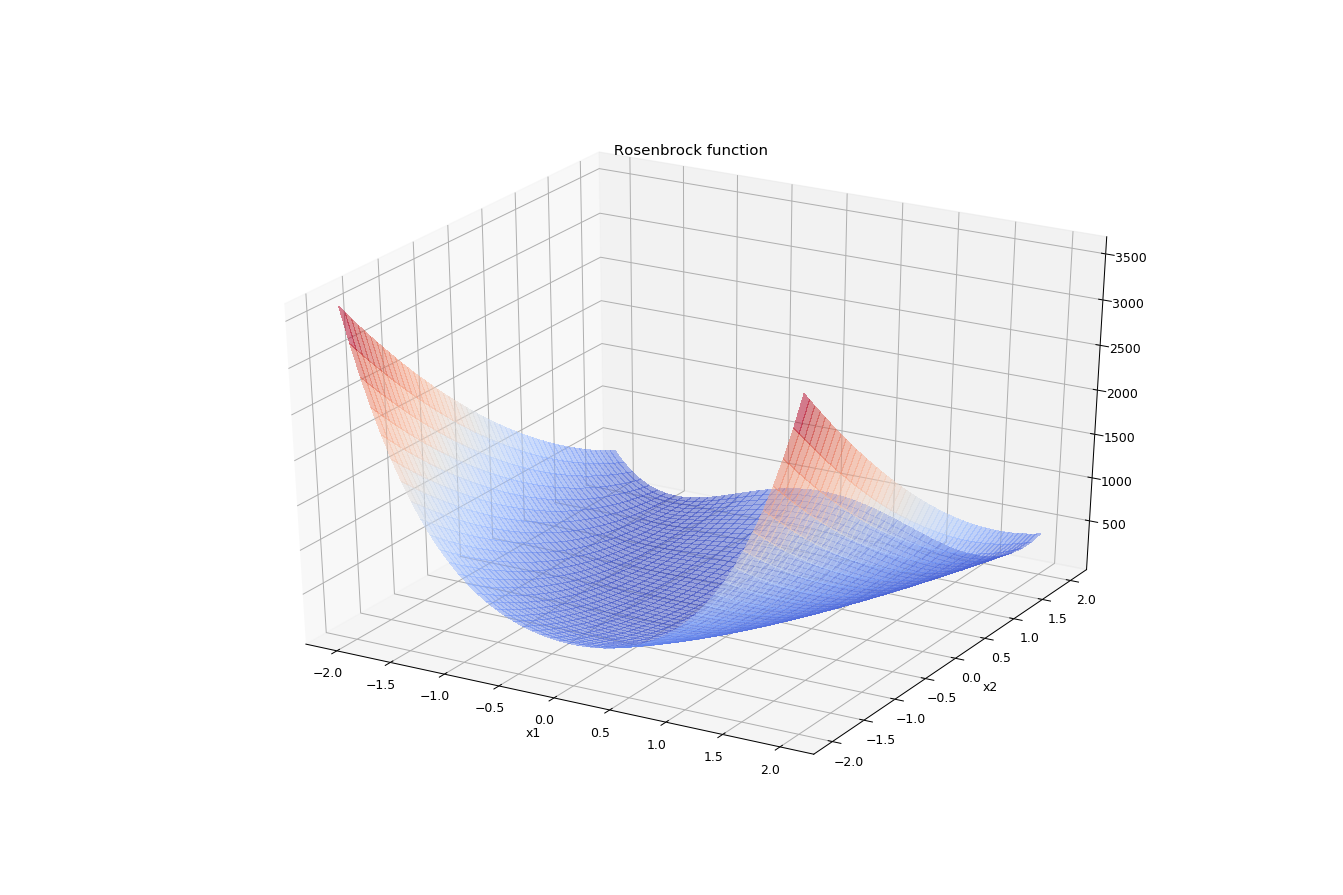

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

print('---------------------------')
print('PLOT  2D Rosenbrock ') 
ndim = 2
ndoe = 5 #(at least ndim+1)
num_plot = 50 #to plot rosenbrock


xlimits=np.array([[-2,2], [-2,2]])


#To plot the Rosenbrock function
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()



You can reuse the code written above or use directly the EGO function within the SMT toolbox

In [12]:
!pip install smt

In [13]:
from smt.applications.ego import EGO
from smt.sampling_methods import LHS

import pandas as pd

In [14]:
print('---------------------------')
print('TEST EGO on   2D Rosenbrock  with SMT toolbox') 



---------------------------
TEST EGO on   2D Rosenbrock  with SMT toolbox


* Choose your criterion to perform the optimization: EI, SBO or UCB
* Choose the size of the initial DOE
* Choose the number of EGO iterations

In [26]:

criterion='EI' #'EI' or 'SBO' or 'UCB'

#number of points in the initial DOE
ndoe = 10 #(at least ndim+1)

#number of iterations with EGO 
n_iter =50

#Build the initial DOE
#generate the DOE with LHS sampling
#sampling = LHS(xlimits=xlimits)
#xdoe = sampling(ndoe)
#or 
#read the DOE in a file
file_name = "doe_init_2D_5points.txt"
#read the DOE in a file
file_name = "doe_init_2D_5points.txt"
#for google colab use url_name
#url_name = "https://raw.githubusercontent.com/dbetteb/early-ML/master/6_GAUSSIAN_PROCESS_BAYESIAN_OPTIM/doe_init_2D_5points.txt"
xdoe = pd.read_csv(url_name, header=None,  delimiter = ',')
xdoe = pd.read_csv(file_name, header=None,  delimiter = ',')
xdoe =  np.array(xdoe[[0,1]])
ydoe = rosenbrock(xdoe)
print(xdoe,ydoe)
#EGO call (given xdoe and ydoe as inputs)
ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe,   xlimits=xlimits)
#if ydoe is knosn, possibilitey to add it in inputs
#ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe, ydoe=ydoe,  xlimits=xlimits)
x_opt, y_opt, ind_best, x_data, y_data, x_doe, y_doe = ego.optimize(fun=rosenbrock)

print('Xopt for Rosenbrock ', x_opt,y_opt, ' obtained using EGO criterion = ', criterion )
print('Check if the optimal point is Xopt= (1,1) with the Y value=0')
print('---------------------------')


[[ 1.55033227  0.5446763 ]
 [-1.12660757 -1.3145414 ]
 [-1.99224528  0.05980725]
 [ 0.04783226  1.21076304]
 [ 0.65780257 -0.88087046]] [[ 345.83662721]
 [ 672.11748251]
 [1537.16457589]
 [ 146.94783388]
 [ 172.66494526]]


AssertionError: Option ydoe has not been declared

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


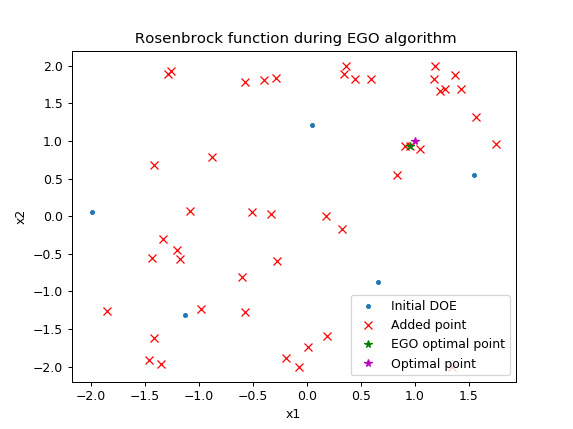

In [16]:
#To plot the Rosenbrock function
#3D plot
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
#to add the points provided by EGO
ax.scatter(x_doe[:,0],x_doe[:,1],y_doe,zdir='z',marker = '.',c='k',s=100, label='Initial DOE')
ax.scatter(x_data[ndoe:,0],x_data[ndoe:,1],y_data[ndoe:],zdir='z',marker = 'x',c='r', s=100, label= 'Added point')
ax.scatter(x_opt[0],x_opt[1],y_opt,zdir='z',marker = '*',c='g', s=100, label= 'EGO optimal point')

plt.title(' Rosenbrock function during EGO algorithm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


#2D plot 
#to add the points provided by EGO
plt.plot(x_doe[:,0],x_doe[:,1],'.', label='Initial DOE')
plt.plot(x_data[ndoe:,0],x_data[ndoe:,1],'x', c='r', label='Added point')
plt.plot(x_opt[0],x_opt[1],'*',c='g', label= 'EGO optimal point')
plt.plot(1, 1,'*',c='m', label= 'Optimal point')

plt.title(' Rosenbrock function during EGO algorithm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


In [17]:
We can now compare the results by using only the mean information provided by surrogate model approximation


SyntaxError: invalid syntax (<ipython-input-17-b6384db62913>, line 1)

In [ ]:
criterion='SBO' #'EI' or 'SBO' or 'UCB'

#number of points in the initial DOE
ndoe = 10 #(at least ndim+1)

#number of iterations with EGO 
n_iter =100

#Build the initial DOE or read it in a file if already existing
#sampling = LHS(xlimits=xlimits)
#xdoe = sampling(ndoe)

x_doe_init=np.loadtxt('doe_init_2D_5points.txt', delimiter = ',')
#y_doe_init=rosenbrock(x_doe_init)


#EGO call
ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe,  xlimits=xlimits)

x_opt, y_opt, ind_best, x_data, y_data, x_doe, y_doe = ego.optimize(fun=rosenbrock)

print('Xopt for Rosenbrock ', x_opt,y_opt, ' obtained using EGO criterion = ', criterion )
print('Check if the optimal point is Xopt= (1,1) with the Y value=0')
print('---------------------------')